This requires you to write a 2D GAN game. I let you to get into the topic yourself, whitout any explonations from my side. You can watch internet, read papers and tutorials (fun, fun, fun).

### Homework

I want you to implement a simple 2D GAN game. The kind of animation, I want to see is like in [this video](https://www.youtube.com/watch?v=KeJINHjyzOU) at 15:30 or in [here](https://habrahabr.ru/post/275429/) but in 2D. You can google, search code at github, whatever, but the network should be based on Theano. 

Basically you will need to come up with true distribution $P$, say mixture of gaussians (surprise me), sample some data from it. Visualize it as a heatmap. To visualize $G$ density you can fix $N$ noise vectors $\{z_i\} \quad i=1,\dots, N$ and draw a circle for each $G(z_i)$. It is also funny to visualize discriminator as a vector field (can be done with `plt.arrow`, `plt.quiver plo). Look how it should be in the middle of [this page](http://www.inference.vc/an-alternative-update-rule-for-generative-adversarial-networks/).

Please, make sure your code works if 'Run All' is pressed and it draws some animation.

Good luck!

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np
import lasagne
import theano
import theano.tensor as T
from lasagne.layers import *
from lasagne.nonlinearities import rectify, sigmoid, linear, tanh
import scipy.stats as st
import seaborn as sns
from IPython import display

In [2]:
def sample_noise(N):
    noise = np.random.random((N,2))
    return noise

In [3]:
mu = -2
sigma = 0.3
M = 3000
N = 3000

In [4]:
# generator
G_input = T.matrix('Gx')
G_l1 = InputLayer((None, 2), G_input)
G_l2 = DenseLayer(G_l1, 10, nonlinearity=rectify)
G_l3 = DenseLayer(G_l2, 10, nonlinearity=rectify)
G_l4 = DenseLayer(G_l3, 2, nonlinearity=linear)
G = G_l4

G_out = get_output(G)

In [5]:
# discriminators
D1_input = T.matrix('D1x')
D1_target = T.matrix('D1y')
D1_l1 = InputLayer((None, 2), D1_input)
D1_l2 = DenseLayer(D1_l1, 10, nonlinearity=tanh)
D1_l3 = DenseLayer(D1_l2, 10, nonlinearity=tanh)
D1_l4 = DenseLayer(D1_l3, 2, nonlinearity=sigmoid)
D1 = D1_l4

D2_l1 = InputLayer((None, 2), G_out)
D2_l2 = DenseLayer(D2_l1, 10, nonlinearity=tanh, W=D1_l2.W, b=D1_l2.b)
D2_l3 = DenseLayer(D2_l2, 10, nonlinearity=tanh, W=D1_l3.W, b=D1_l3.b)
D2_l4 = DenseLayer(D2_l3, 2, nonlinearity=sigmoid, W=D1_l4.W, b=D1_l4.b)
D2 = D2_l4

D1_out = get_output(D1)
D2_out = get_output(D2)

In [6]:
def plot_f(x, y ,color):
    
    xy = np.vstack([x,y])
    density = st.gaussian_kde(xy)(xy) 

    idx = density.argsort()
    x, y, density = x[idx], y[idx], density[idx]
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x, y, density,color = color )
    plt.show()

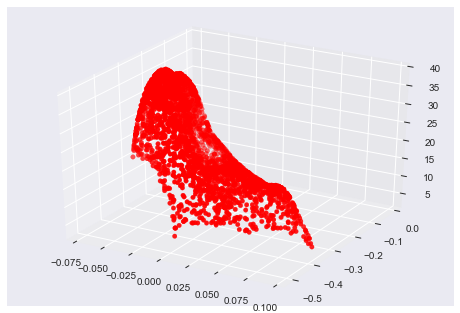

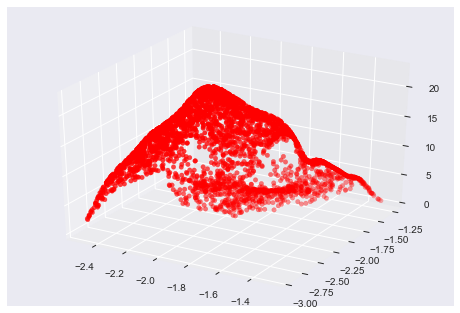

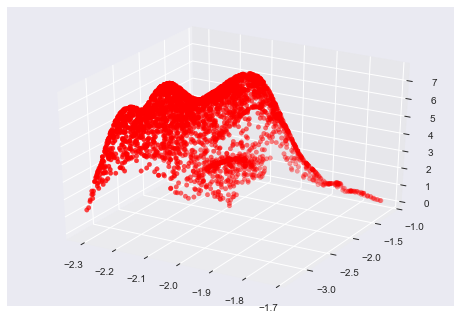

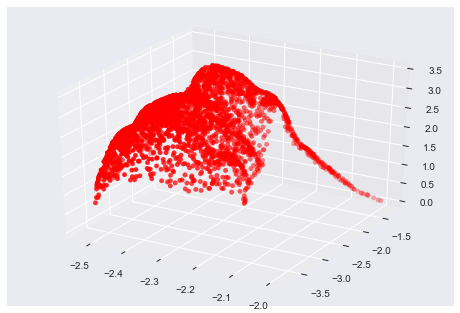

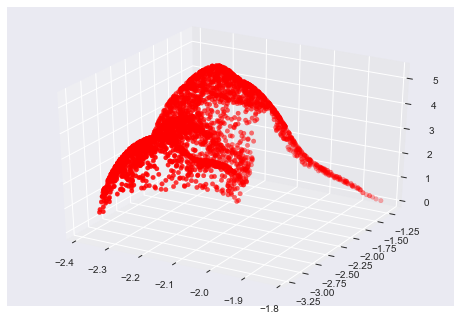

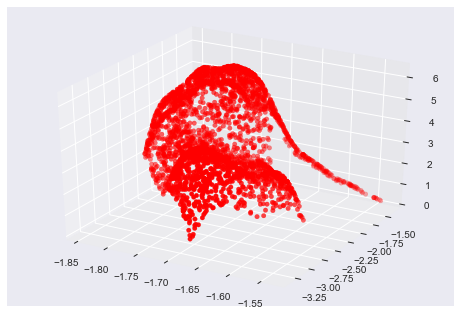

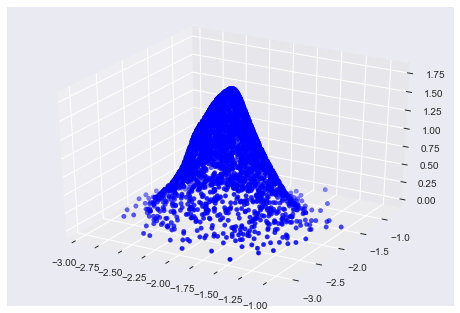

In [7]:
# output functions
discriminate = theano.function([D1_input], D1_out)
generate = theano.function([G_input], G_out)

G_obj = (T.log(D2_out)).mean()
D_obj = (T.log(D1_out) + T.log(1 - D2_out)).mean()

# parameters update and training
G_params = lasagne.layers.get_all_params(G, trainable=True)
G_lr = theano.shared(np.array(0.01, dtype=theano.config.floatX))
G_updates = lasagne.updates.nesterov_momentum(1 - G_obj, G_params, learning_rate=G_lr, momentum=0.6)
G_train = theano.function([G_input], G_obj, updates=G_updates)

D_params = lasagne.layers.get_all_params(D1, trainable=True)
D_lr = theano.shared(np.array(0.1, dtype=theano.config.floatX))
D_updates = lasagne.updates.nesterov_momentum(1 - D_obj, D_params, learning_rate=D_lr, momentum=0.6)
D_train = theano.function([G_input, D1_input], D_obj, updates=D_updates)

epochs = 100
k = 20

visualize_training = True   # set to True to monitor training progress

plt.ion()
x = np.float32(np.random.normal(mu, sigma, (M,2))) # sampled m-batch from p_data

for i in range(epochs):
    for j in range(k):
        x = np.float32(np.random.normal(mu, sigma, (M,2))) # sampled m-batch from p_data
        z = sample_noise(M) # sample m-batch from noise prior
        D_train(z, x)
    z = sample_noise(M)
    G_train(z)
    L = generate(z)
    if i % 10 == 0:
            G_lr *= 0.999
            D_lr *= 0.999
            
    if visualize_training and i%20==0:
        plot_f(L[:,0],L[:,1],'red')


plot_f(L[:,0],L[:,1],'red')
plot_f(x[:,0],x[:,1],'blue')